# Setup environment

In [72]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/')
    data_folder = Path('/content/drive/MyDrive/data/cifar10_data/')

    !pip install pytorch-lightning==2.0.9 -qq

    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

else:
    base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor')
    data_folder = Path('/home/harpreet/data')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
custom_function_folder = base_folder/'Colab Notebooks/Custom'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'data/models/dl_fall_2023/dog_breed/oct-17'
model_folder.mkdir(parents=True, exist_ok=True)
#project_folder = base_folder/'data/imagenette2'
project_folder = base_folder/'Colab Notebooks/Custom'
kaggle_api_folder = base_folder/'data/.kaggle'

In [74]:
# import Libraries
import yaml

import torch
import torch.nn as nn
import torchmetrics
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

#from data_module_imagenette2 import ImagenetteDataModule
from data_module_cifar10 import CIFAR10DataModule
from multiclass_lightning_module_v0 import MultiClassLightningModule
from model_two_layer_bn import TwoLayerMLPBN
from shared_utils import check_loader, check_transforms, check_label_dist, show_confusion_matrix, compute_accuracy, plot_losses_acc

In [75]:
!pip show pytorch-lightning

Name: pytorch-lightning
Version: 2.0.9
Summary: PyTorch Lightning is the lightweight PyTorch wrapper for ML researchers. Scale your models. Write less boilerplate.
Home-page: https://github.com/Lightning-AI/lightning
Author: Lightning AI et al.
Author-email: pytorch@lightning.ai
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: fsspec, lightning-utilities, numpy, packaging, PyYAML, torch, torchmetrics, tqdm, typing-extensions
Required-by: 


In [76]:
dm = CIFAR10DataModule()
dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [77]:
#trans1 = transforms.ToTensor()

# Transform 2: Normalize the tensor images.
# The specified mean and standard deviation values are dataset-specific.
#trans2 = transforms.Normalize((0.2857,), (0.3528))

# Combine the above transformations into a single composite transform.
#trans = transforms.Compose([trans1, trans2])

In [78]:
normalize = transforms.Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784) )
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop([45,45]),
    # transforms.Resize(size=(224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop([50,50]),
    # transforms.RandomRotation(degrees=45),
    # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    normalize,
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    # transforms.Resize(size=(224, 224)),
    # transforms.CenterCrop([50,50]),
    normalize,
])

# Model

In [79]:
import torchvision.models as models
def load_model(config):
    model = models.vgg16(weights="DEFAULT")

    for param in model.parameters():
        param.requires_grad = False


    for i in range(0,6):
        for param in model.classifier[i].parameters():
            param.requires_grad = True

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, out_features=10,bias=True)
    return model

In [80]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

model = load_model([])
total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")


Total parameters: 134301514
Trainable parameters: 119586826


# Function to load the model

# Functions for Transformations

# Function to load DataModule

In [81]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = trans  # Assuming you have a transform function named 'trans'
    test_transform = trans  # Assuming the same transform for train and test

    dm = CIFAR10DataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm



# Function to load LightningModule

In [82]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module


# Function to load the Trainer

In [83]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger, wandb_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer



# Function to load components

In [84]:
def load_components(model_config, data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model(model_config)

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [85]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# Function to Load config files

In [86]:
# Load configurations from YAML files
def load_all_configs():
    model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config1.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config1.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return model_config, data_module_config, lightning_module_config, cl_config, trainer_config



# Function to free memory

In [87]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# Run One training and validation batch to check bugs

In [88]:
# Load components
free_memory()
seed_everything(42)
_, _, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
model_config = {'num_classes': 10}
data_module_config = {'data_module': {'batch_size': 64, 'seed': 42}}
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


100%|██████████| 170498071/170498071 [00:05<00:00, 29442620.59it/s]


Extracting /content/drive/MyDrive/data/cifar10_data/cifar-10-python.tar.gz to /content/drive/MyDrive/data/cifar10_data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to i

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.24, Val_Metric: 0.20 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.60, Train_Metric: 0.11


# Find Learning Rate

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.38, Val_Metric: 0.12 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: Val_Loss: 53.19, Val_Metric: 0.11 | 

INFO:pytorch_lightning.tuner.lr_finder:LR finder stopped early after 19 steps due to diverging loss.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.0010000000000000002
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_4b89d956-d78c-4df3-86a7-c1ff6dc8a76e.ckpt


Train_Loss: 5.74, Train_Metric: 0.31


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_4b89d956-d78c-4df3-86a7-c1ff6dc8a76e.ckpt


0.0010000000000000002


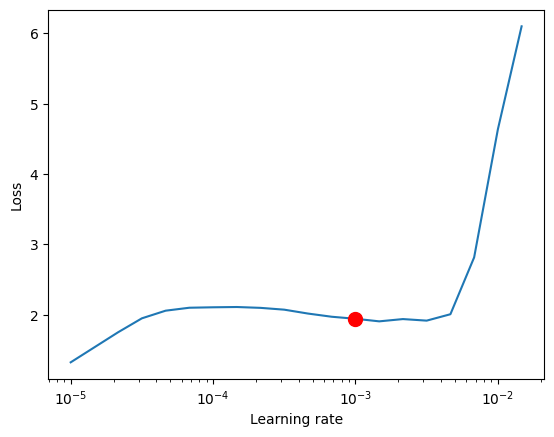

In [89]:
free_memory()
seed_everything(42)
_, _, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
model_config = {'num_classes': 10}
data_module_config = {'data_module': {'batch_size': 64, 'seed': 42}}
# override default values
trainer_config['max_epochs']=5
data_module_config['data_module']['batch_size']=128

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup('fit')
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)


In [90]:
free_memory()
seed_everything(42)
_, _, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
model_config = {'num_classes': 10}
data_module_config = {'data_module': {'batch_size': 64, 'seed': 42}}

# override default values
data_module_config['data_module']['batch_size']=128
lightning_module_config['others']['learning_rate']=0.001
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=20

lightning_module_config['others']['optimizer_params']['weight_decay']=1
lightning_module_config['others']['learning_rate']=0.003
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.ReduceLROnPlateau'
lightning_module_config['scheduler_params']= {'mode': 'max', 'patience': 0, 'factor': 0.5, 'verbose': True}
lightning_module_config['scheduler_options']= {'monitor': 'val_loss', 'interval': 'epoch', 'frequency': 1}
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='fminst'
cl_config['wandb']['name']='resnet'

# data_module_config['data_module']['small_subset']=True
# data_module_config['data_module']['num_samples_small']=0.5

model, dm, lightning_module, trainer = load_components(model_config, data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=True)
dm.setup('fit')
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:398: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the ba

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
119 M     Trainable params
14.7 M    Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.34, Val_Metric: 0.13 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.57, Val_Metric: 0.47 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved. New best score: 0.466


Train_Loss: 2.94, Train_Metric: 0.36


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.47, Val_Metric: 0.51 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.042 >= min_delta = 0.0. New best score: 0.508


Train_Loss: 1.87, Train_Metric: 0.37
Epoch 00002: reducing learning rate of group 0 to 1.5000e-03.


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.21, Val_Metric: 0.59 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.084 >= min_delta = 0.0. New best score: 0.592


Train_Loss: 1.58, Train_Metric: 0.46
Epoch 00003: reducing learning rate of group 0 to 7.5000e-04.


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.11, Val_Metric: 0.64 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.044 >= min_delta = 0.0. New best score: 0.636


Train_Loss: 1.33, Train_Metric: 0.56
Epoch 00004: reducing learning rate of group 0 to 3.7500e-04.


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.02, Val_Metric: 0.66 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.029 >= min_delta = 0.0. New best score: 0.665


Train_Loss: 1.16, Train_Metric: 0.61
Epoch 00005: reducing learning rate of group 0 to 1.8750e-04.


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.97, Val_Metric: 0.68 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.011 >= min_delta = 0.0. New best score: 0.676


Train_Loss: 1.02, Train_Metric: 0.65
Epoch 00006: reducing learning rate of group 0 to 9.3750e-05.


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.93, Val_Metric: 0.69 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.010 >= min_delta = 0.0. New best score: 0.686


Train_Loss: 0.93, Train_Metric: 0.68
Epoch 00007: reducing learning rate of group 0 to 4.6875e-05.


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.92, Val_Metric: 0.69 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.003 >= min_delta = 0.0. New best score: 0.689


Train_Loss: 0.88, Train_Metric: 0.70
Epoch 00008: reducing learning rate of group 0 to 2.3438e-05.


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.92, Val_Metric: 0.69 | 

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_metric improved by 0.005 >= min_delta = 0.0. New best score: 0.693


Train_Loss: 0.84, Train_Metric: 0.71
Epoch 00009: reducing learning rate of group 0 to 1.1719e-05.


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.91, Val_Metric: 0.69 | Train_Loss: 0.82, Train_Metric: 0.71
Epoch 00010: reducing learning rate of group 0 to 5.8594e-06.


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [91]:
file = f"{trainer.logger.log_dir}/metrics.csv"
print(file)

/content/drive/MyDrive/data/models/dl_fall_2023/dog_breed/oct-17/logs/csvlogger/version_7/metrics.csv


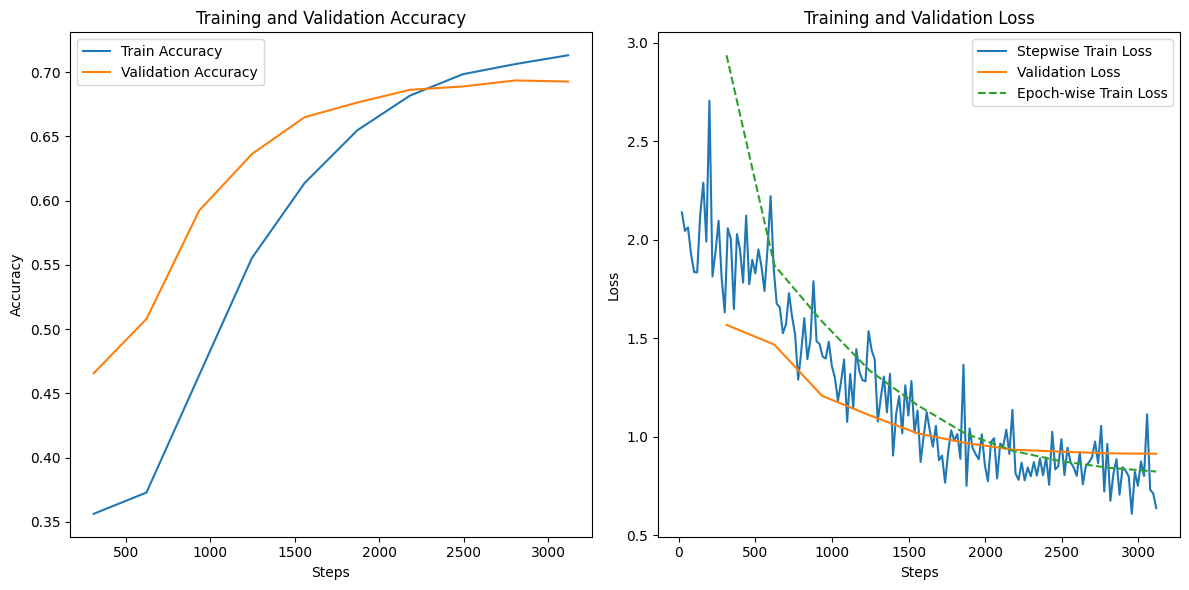

In [92]:
plot_losses_acc(file)